# Estimating optimal growth periods based on temperatures in seasonal subdaily forecast

Production date: 25.09.2025

Produced by: Johanna Tjernström, Johannes Langvatn

## 🌍 Use case: Investigation of diurnal temperature ranges, and mimimun and maximum temperature in relation to crop growth

## ❓ Quality assessment question
* **Can seasonal forecasts of minimum and maximum temperature be used to draw conclusions about growth conditions for common crops?**

**‘Context paragraph’ (no title/heading)** - a very short introduction before the assessment statement describing approach taken to answer the user question. One or two key references could be useful,  if the assessment summarises literature . These can be referenced directly in the text, like `[Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2)` giving: [Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2). For major references numerical labels like this should be used (which should also listed at the end) `Rodriguez et. al. 2018, [[1]](https://doi.org/10.5194/gmd-17-1249-2024))`giving: Rodriguez et. al. 2018, [[1]](https://doi.org/10.5194/gmd-17-1249-2024)). Please use DOI links where possible.


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* To be found
```

## 📋 Methodology

A ‘free text’ introduction to the data analysis steps or a description of the literature synthesis, with a justification of the approach taken, and limitations mentioned. **Mention which CDS catalogue entry is used, including a link, and also any other entries used for the assessment**.

Followed by a numbered list of the methodology and results, with the same headings as the sections under ‘Analysis and Results’. These should be links to the sections below, using the format `[](section-label)`. The title of the section will be automatically populated, so no need to repeat the title of the section when referecing it like this.

```{note}
The section labels for the links need to be manually set, as seen below (`(section-1)=`, followed by the heading). These labels will be shown in GitHub but will not appear when the Jupyter Book page is built.
```

* These headings can be specific to the quality assessment, and help guide the user through the ‘story’ of the assessment. This means we cannot pre-define the sections and headings here, as they will be different for each assessment.
* Sub-bullets could be used to outline what will be done/shown/discussed in each section
* The list below is just an example, or may need more or fewer sections, with different headings

E.g. 'The analysis and results are organised in the following steps, which are detailed in the sections below:' 

**[](section-1)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-2)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-3)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.


## 📈 Analysis and results

(section-1)=
### 1. Download data and select region and crop of interest

Import packages to be used in the notebook

In [27]:
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from c3s_eqc_automatic_quality_control import diagnostics, download, utils
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.colors as col
from ibicus.debias import ISIMIP

Define functions to be used later in the plotting

In [28]:
def meanfunc(ds):
    ds = ds.mean("realization")
    return ds

def plot_maps(years,ds,number_columns,growth_time):

    norm = col.Normalize(ds.values.min(),ds.values.max())
    
    cols = number_columns
    rows = int(len(years) / cols)
    
    if cols * rows != len(years):
        rows = rows + 1 
        
    fig, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(15, 15),subplot_kw={'projection': ccrs.PlateCarree()})
    
    plot = 0
    row = 0
    
    for year in years:
        plant_month = pd.Timestamp(str(year)+"-04-01")#april
        end_month = plant_month + growth_time
    
        selection = pd.date_range(str(year)+"-03",str(year)+"-10", inclusive = "left")
        
        monthly_mean = ds.sel(time=selection,method="nearest").mean(dim="time")
    
        cfax = ax[row,plot].contourf(monthly_mean.longitude,monthly_mean.latitude,monthly_mean.values,
                           transform=ccrs.PlateCarree(),norm=norm,cmap="coolwarm",levels=100)
        ax[row,plot].coastlines()
        ax[row,plot].set_title(year)
        
        plot += 1
        if plot > cols -1:
    
            plot = 0
            row += 1

    cmap = mpl.cm.coolwarm
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', label='Degrees celsius')
    cbar.ax.set_position([0.3, 0.30, 0.4, 0.02])
    plt.show()

def plot_years(years, ds, number_columns, growth_time):

    norm = (ds.t2m_min.values.min()-273.15,ds.t2m_max.values.max()-273.15)

    cols = number_columns
    rows = int(len(years) / cols)
    
    if cols * rows != len(years):
        rows = rows + 1 
        
    fig, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(15, 15))
    
    plot = 0
    row = 0
    
    for year in years:
        plant_month = pd.Timestamp(str(year)+"-04-01")#april
        end_month = plant_month + growth_time
    
        selection = pd.date_range(str(year)+"-03",str(year)+"-10", inclusive = "left")
        t_max = ds.t2m_max.sel(time=selection,method="nearest")-273.15
        t_min = ds.t2m_min.sel(time=selection,method="nearest")-273.15
       
        ax[row,plot].plot(t_max.time,t_max,label="max temp")
        ax[row,plot].plot(t_min.time,t_min,label="min temp")
        
        ax[row,plot].axvline(x=plant_month, color='red', linestyle='--', linewidth=2,label="Growth season")
        ax[row,plot].axvline(x=end_month, color='red', linestyle='--', linewidth=2)
        ax[row,plot].axhline(y=max_growing_temp, color='blue', linestyle='--', linewidth=2, label = "Optimal temperature window")
        ax[row,plot].axhline(y=min_growing_temp, color='blue', linestyle='--', linewidth=2)
        plt.title("Max/min temperature and growth window for Wheat in Europe, str(year), (35-45°lat)")
        ax[row,plot].set_title(year)
        ax[row,plot].set_ylim(norm)
        ax[row,plot].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

        plot += 1
        if plot > cols -1:
            plot = 0
            row += 1
    plt.tight_layout()
    plt.show()


Downloading reference reanalysis data (ERA5)

In [29]:
dataset = "derived-era5-single-levels-daily-statistics"

request= {
    "product_type": "reanalysis",
    "variable": ["2m_temperature"],
    "year": [
        "1981", "1982", "1983",
        "1984", "1985", "1986",
        "1987", "1988", "1989",
        "1990", "1991", "1992",
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016"
    ],
    "month": [
        "03", "04", "05",
        "06", "07", "08"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "time_zone": "utc+00:00",
    "frequency": "1_hourly",
    "grid": "1/1",
    "area": [55, 0, 45, 40]
}
kwargs = {
    "chunks": {"year": 1},
    "n_jobs": 1,
}

request["daily_statistic"] = "daily_minimum"
era5_min = download.download_and_transform(
    dataset,
    request,
    **kwargs,
)
request["daily_statistic"] = "daily_maximum"
era5_max = download.download_and_transform(
    dataset,
    request,
    **kwargs,
)
ERA5 = xr.merge([era5_min.rename({"t2m": "t2m_min"}), era5_max.rename({"t2m": "t2m_max"})], compat="override")

100%|██████████| 36/36 [00:00<00:00, 56.21it/s]


In [30]:
days = 215
leadtime_hour = [(day + 1) * 24 for day in range(days)]

Downloading reference hindcast data, and forecast data

In [31]:
collection_id_max_min = "seasonal-original-single-levels"
request_hindcast = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "maximum_2m_temperature_in_the_last_24_hours",
        "minimum_2m_temperature_in_the_last_24_hours"
    ],
    "year": [
        "1981", "1982", "1983",
        "1984", "1985", "1986",
        "1987", "1988", "1989",
        "1990", "1991", "1992",
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016"
    ],
    "month": ["03"],
    "day": ["01"],
    "leadtime_hour": leadtime_hour,
    "data_format": "grib",
    "area": [55, 0, 45, 40]

}

request_max_min = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "maximum_2m_temperature_in_the_last_24_hours",
        "minimum_2m_temperature_in_the_last_24_hours"
    ],
    "year": ["2025"],
    "month": ["03"],
    "day": ["01"],
    "leadtime_hour": leadtime_hour,
    "data_format": "grib",
    "area": [55, 0, 45, 40]
}

kwargs = {
    "chunks": {"year": 1},
    "n_jobs": 1,
    "backend_kwargs": {"time_dims": ["valid_time"]},
}

da_max_min = download.download_and_transform(
    collection_id_max_min,
    request_max_min,
    **kwargs,
)

kwargs["transform_func"] = meanfunc
kwargs["transform_chunks"] = False

da_hindcast = download.download_and_transform(
    collection_id_max_min,
    request_hindcast,
    **kwargs,
)


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]
/data/common/miniforge3/envs/wp3/lib/python3.12/site-packages/earthkit/data/utils/kwargs.py:59: UserWarning: In xarray_open_dataset_kwargs backend_kwargs, overriding the default value (squeeze=False) with squeeze=True is not recommended.
  warnings.warn(


Setting constants to be used in the notebook, here we have used Wheat as an example from [Food and Agriculture Organization of the United Nations \[2\]](https://www.fao.org/land-water/databases-and-software/crop-information/wheat/en/): Mean daily temperature for optimum growth and tillering is between 15 and 20°C. It is specially suceptible to springtime frost, mean daily temperatures of less than 10 to 12°C during the growing season make wheat a hazardous crop. Growing takes about 100 to 130 days


In [32]:
max_growing_temp = 20
min_growing_temp = 15
hazard_max = 12
hazard_min = 10
growth_time = pd.Timedelta(130,"D")

In [33]:
tas_max_hindcast = da_hindcast["mx2t24"]
tas_min_hindcast = da_hindcast["mn2t24"]

In [34]:
tas_max = da_max_min["mx2t24"].isel(realization=0)
tas_min = da_max_min["mn2t24"].isel(realization=0)

In [35]:
debiaser = ISIMIP.from_variable("tas")

In [36]:
min_debiased = debiaser.apply(ERA5.t2m_min.values, tas_min_hindcast.values, tas_min.values)

  0%|          | 0/451 [00:00<?, ?it/s]/data/common/miniforge3/envs/wp3/lib/python3.12/site-packages/ibicus/debias/_debiaser.py:387: UserWarning: ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information.
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
  return func(obs, cm_hist, cm_future, **kwargs)
/data/common/miniforge3/envs/wp3/lib/python3.12/site-packages/ibicus/debias/_isimip.py:564: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  regression = scipy.stats.linregress(unique_years, annual_means)
100%|██████████| 451/451 [07:52<00:00,  1.05s/it]


In [37]:
min_bias = tas_min - min_debiased

In [38]:
max_debiased = debiaser.apply(ERA5.t2m_max.values, tas_max_hindcast.values, tas_max.values)

  0%|          | 0/451 [00:00<?, ?it/s]/data/common/miniforge3/envs/wp3/lib/python3.12/site-packages/ibicus/debias/_debiaser.py:387: UserWarning: ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information.
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
  return func(obs, cm_hist, cm_future, **kwargs)
/data/common/miniforge3/envs/wp3/lib/python3.12/site-packages/ibicus/debias/_isimip.py:564: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  regression = scipy.stats.linregress(unique_years, annual_means)
100%|██████████| 451/451 [07:46<00:00,  1.03s/it]


In [39]:
max_bias = tas_max - max_debiased

In [40]:
da_max_min["max_debiased"] = (["realization", "time","latitude","longitude"], da_max_min["mx2t24"].values - max_bias.values)
da_max_min["min_debiased"] =  (["realization", "time","latitude","longitude"], da_max_min["mn2t24"].values - min_bias.values)

In [41]:
slice_europe_max = da_max_min["max_debiased"]
slice_europe_min = da_max_min["min_debiased"]


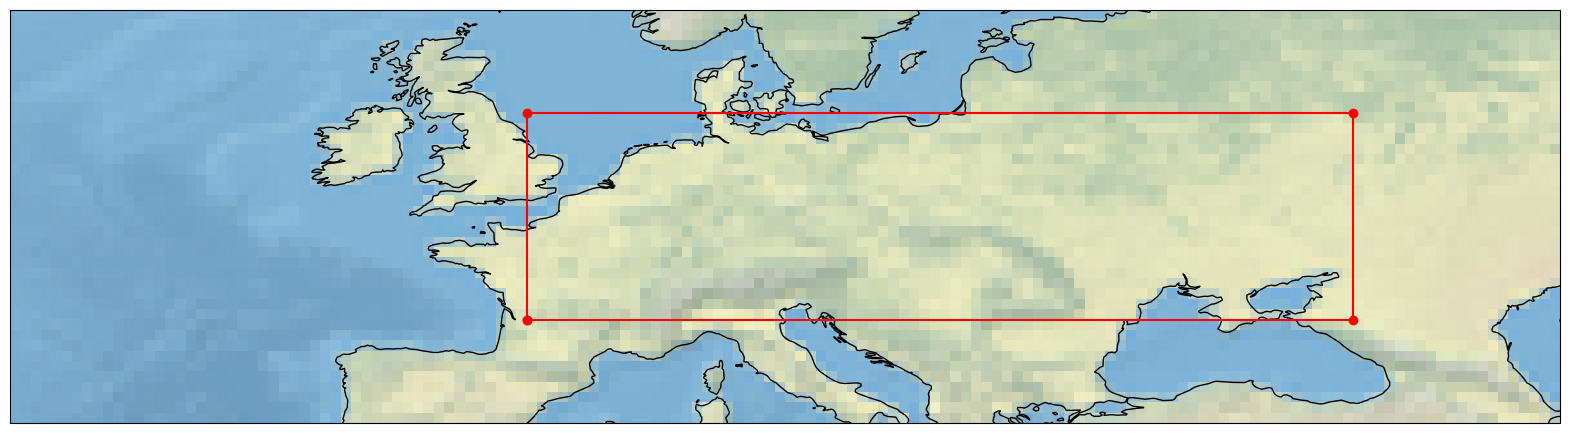

In [42]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-25, 50, 40, 60],crs=ccrs.PlateCarree())
longitudes = [slice_europe_max.longitude[0],slice_europe_max.longitude[-1],slice_europe_max.longitude[-1],slice_europe_max.longitude[0],slice_europe_max.longitude[0]]
latitidues = [slice_europe_max.latitude[-1],slice_europe_max.latitude[-1],slice_europe_max.latitude[0],slice_europe_max.latitude[0], slice_europe_max.latitude[-1]]
ax.plot(longitudes, latitidues, marker='o', color='red', transform=ccrs.PlateCarree());


(section-2)=
### 2. Temperature extreme trends year to year


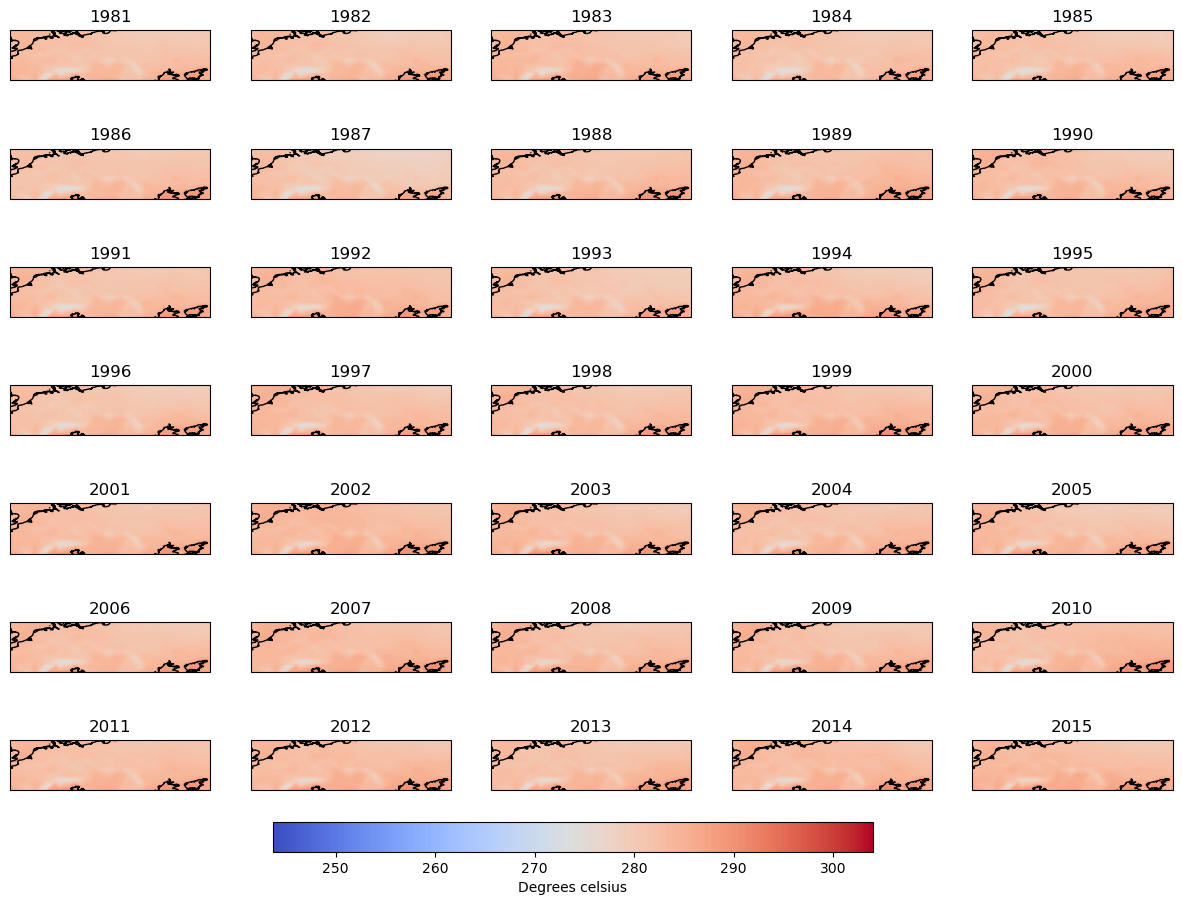

In [43]:
plot_maps(range(1981,2016),ERA5.t2m_min,5,growth_time)


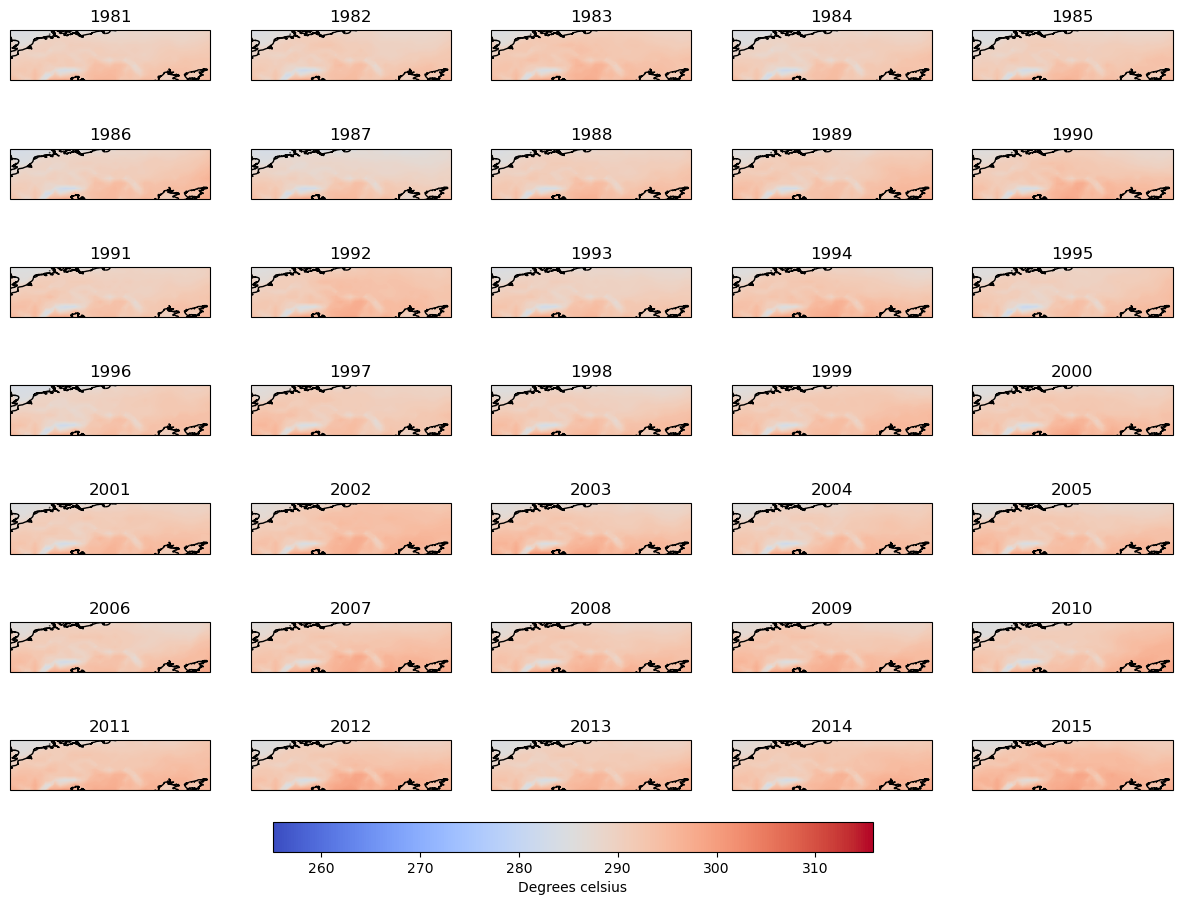

In [44]:
plot_maps(range(1981,2016),ERA5.t2m_max, 5,growth_time)


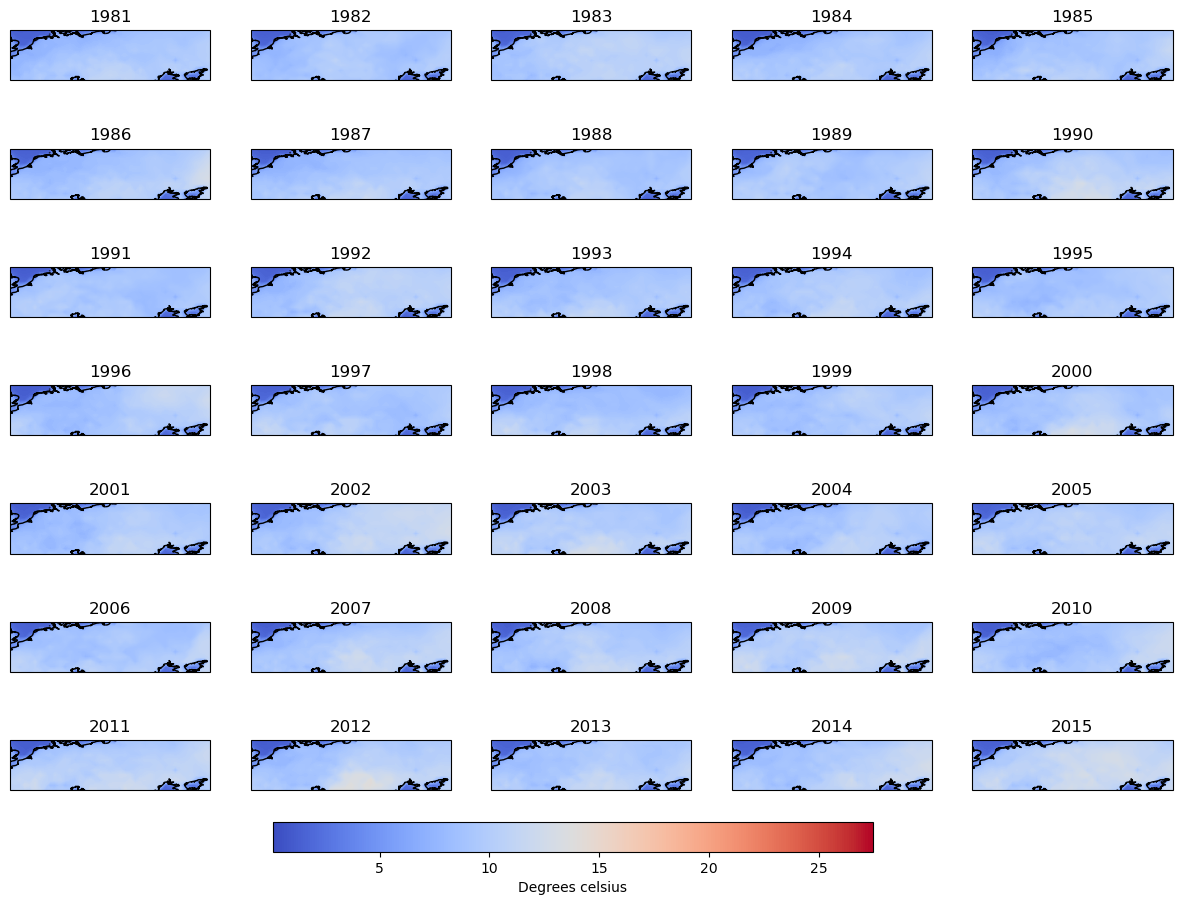

In [45]:
plot_maps(range(1981,2016),ERA5.t2m_max - ERA5.t2m_min,5,growth_time)


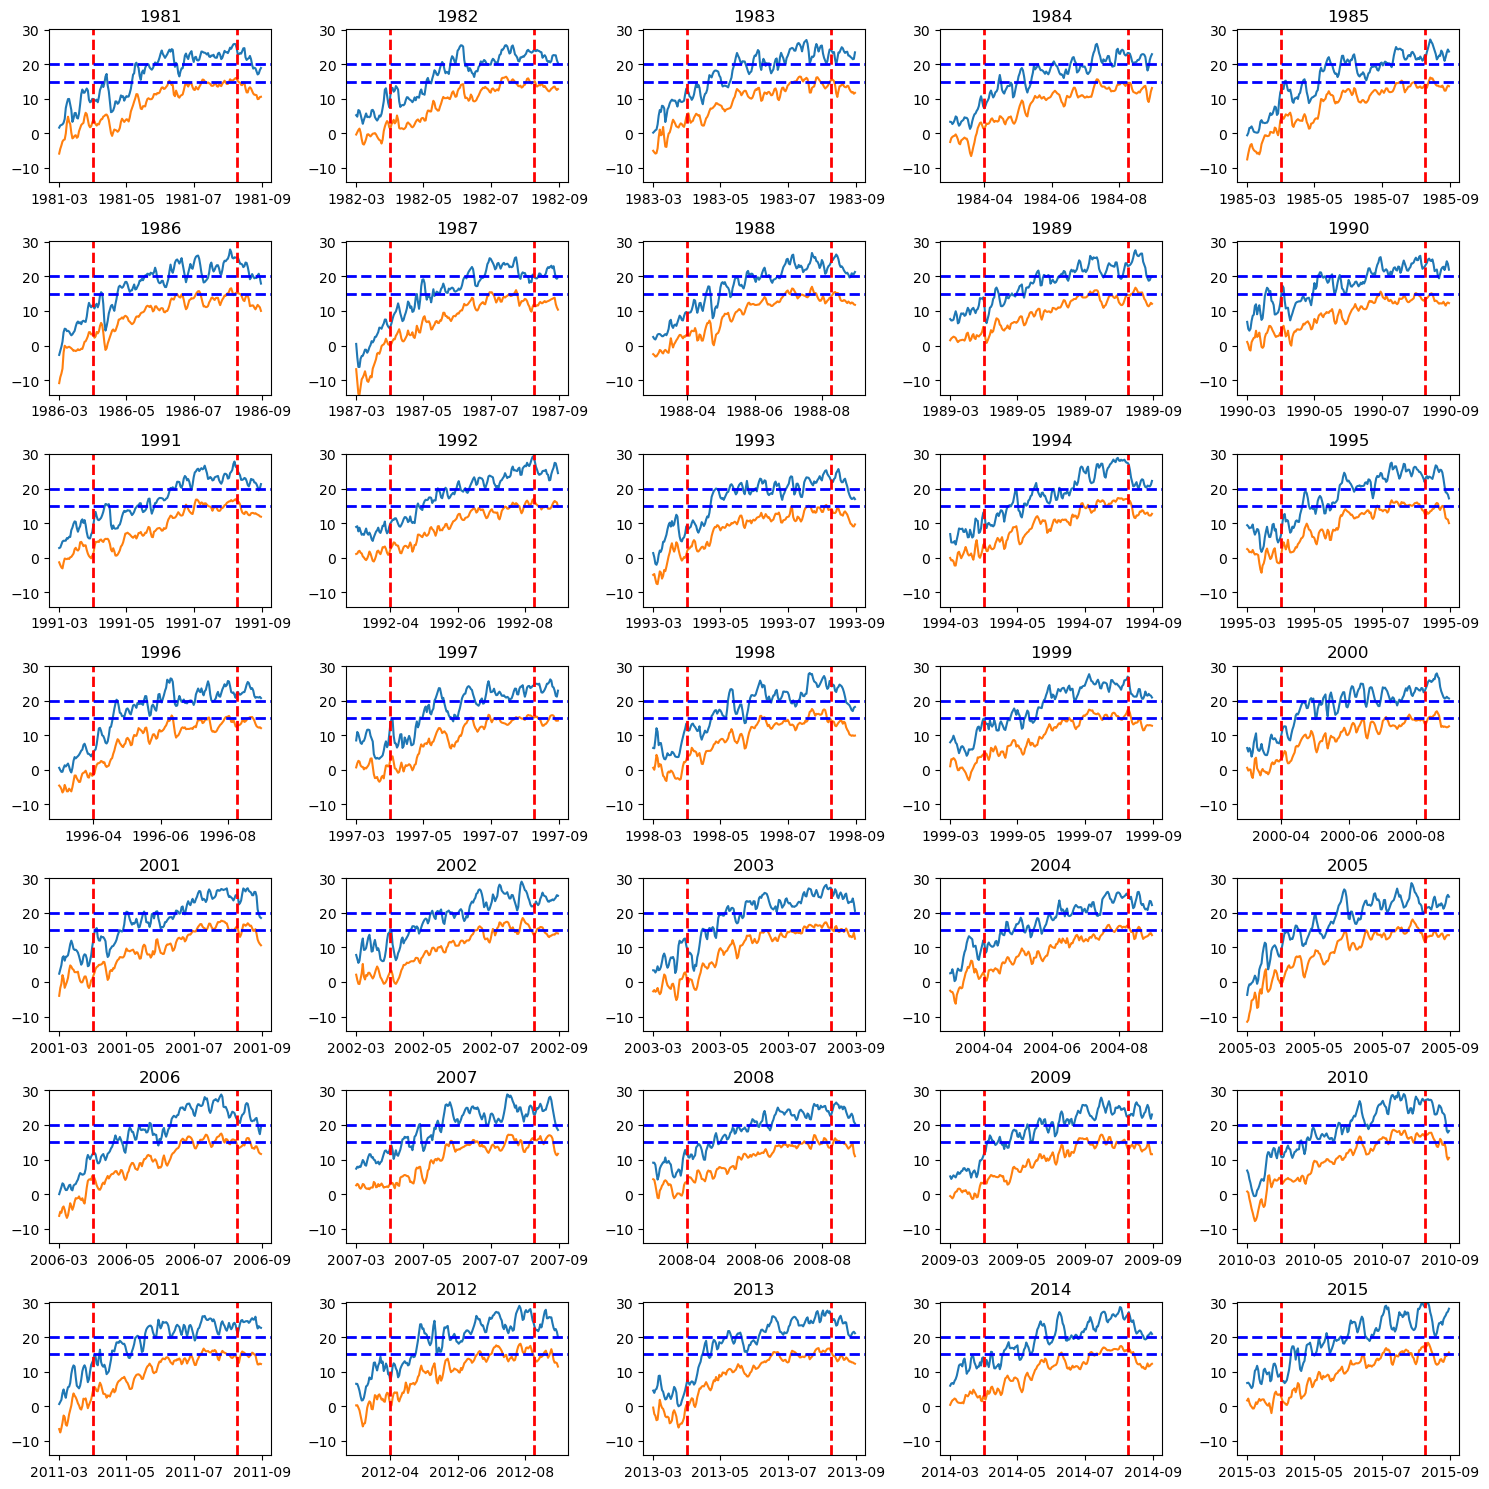

In [46]:
area_ERA5 = diagnostics.spatial_weighted_mean(ERA5)
plot_years(range(1981,2016), area_ERA5, 5, growth_time)

(section-3)=
### 3. Plot the temperature data with growth season and optimal temperature window

Computing the area max, min, mean and standard deviation for the future growth season.

In [47]:
area_mean_max = diagnostics.spatial_weighted_mean(slice_europe_max)
area_mean_min = diagnostics.spatial_weighted_mean(slice_europe_min)

area_std_max = np.std(area_mean_max,axis=0)
area_std_min = np.std(area_mean_min,axis=0)

area_mean_max = area_mean_max.mean("realization")-273.15
area_mean_min = area_mean_min.mean("realization")-273.15


Plotting the maximum and minimum temperatures against the growth season and optimal temperature window for the chosen crop.

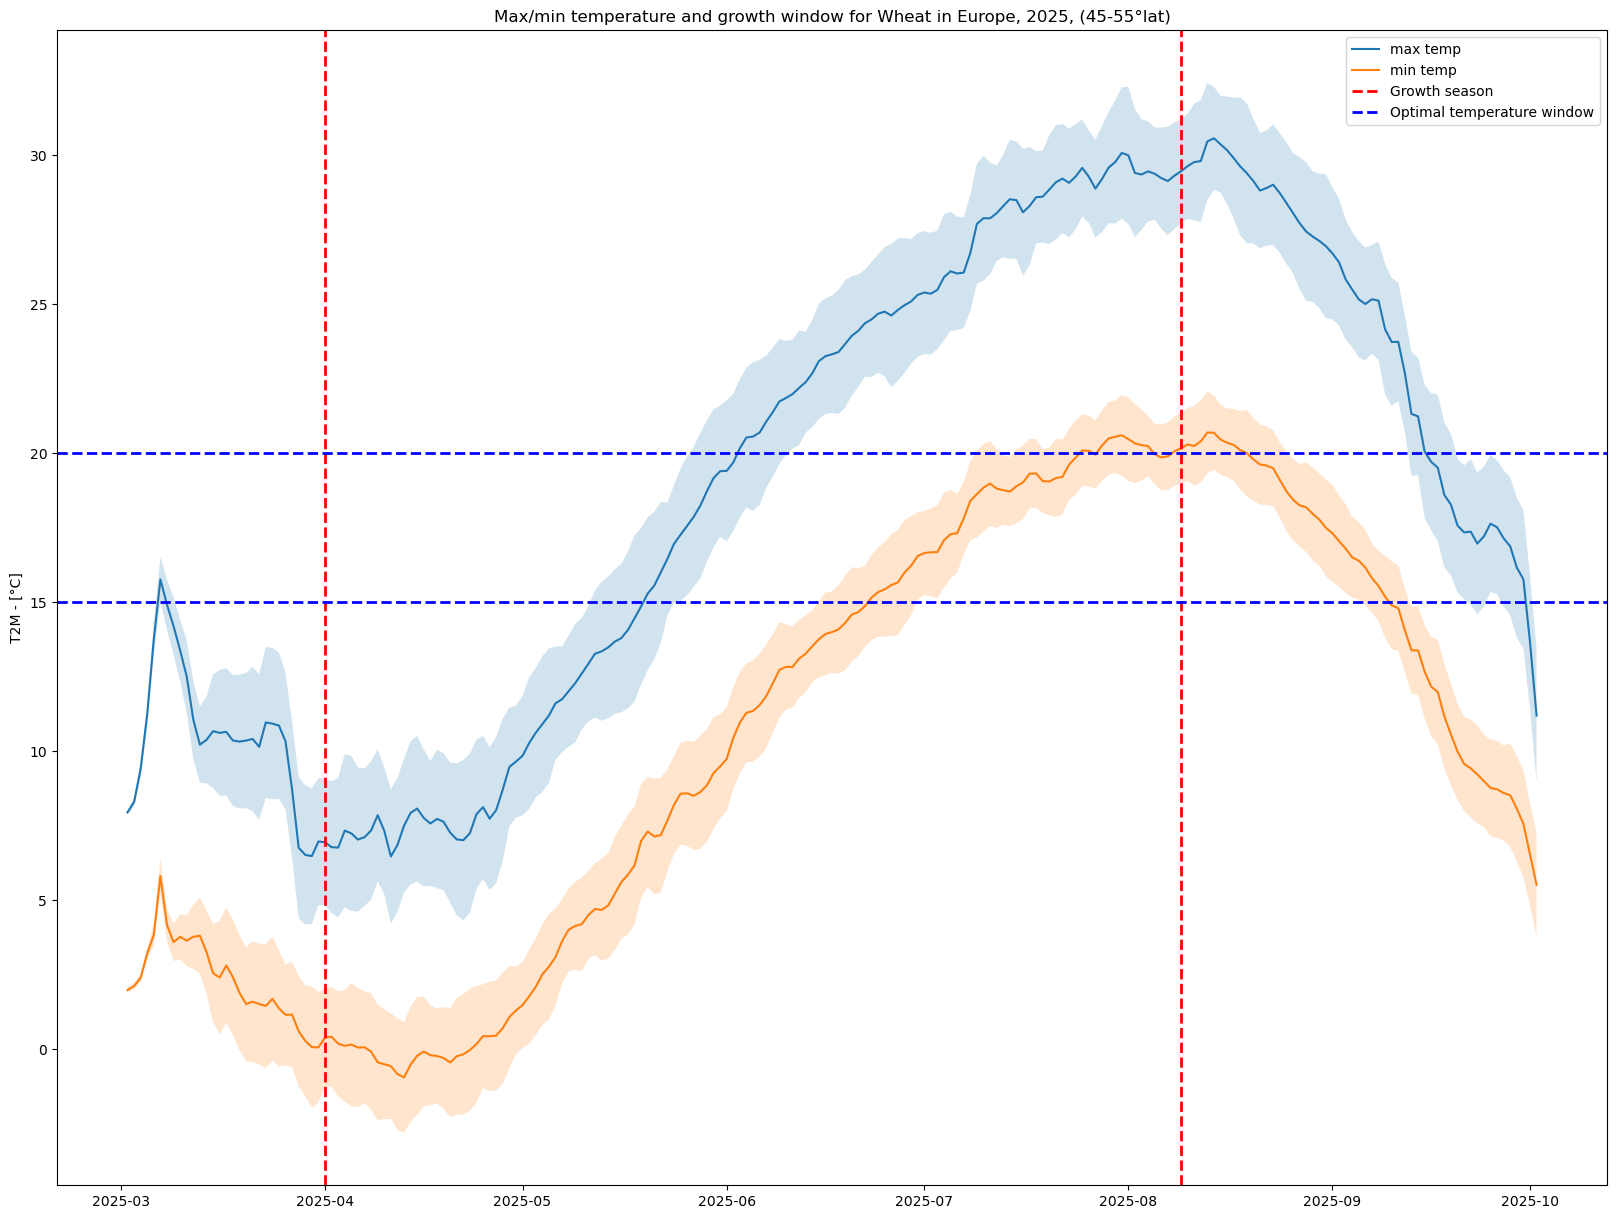

In [48]:
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot(1,1,1)
plant_month = pd.Timestamp("2025-04-01")#april
end_month = plant_month + growth_time
ax1.plot(area_mean_max.time,area_mean_max,label="max temp")
ax1.fill_between(area_mean_max.time, area_mean_max - area_std_max,area_mean_max + area_std_max , alpha=0.2)
ax1.plot(area_mean_min.time,area_mean_min,label="min temp")
ax1.fill_between(area_mean_min.time, area_mean_min - area_std_min,area_mean_min + area_std_min , alpha=0.2)


ax1.axvline(x=plant_month, color='red', linestyle='--', linewidth=2,label="Growth season")
ax1.axvline(x=end_month, color='red', linestyle='--', linewidth=2)
ax1.axhline(y=max_growing_temp, color='blue', linestyle='--', linewidth=2, label = "Optimal temperature window")
ax1.axhline(y=min_growing_temp, color='blue', linestyle='--', linewidth=2)
plt.title("Max/min temperature and growth window for Wheat in Europe, 2025, (45-55°lat)")
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_ylabel("T2M - [°C]")
ax1.legend()
plt.show()

## ℹ️ If you want to know more

### Key resources

 * Seasonal forecast daily and subdaily data on single levels: [10.24381/cds.181d637e](https://doi.org/10.24381/cds.181d637e)

### Code libraries used:
 * [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
 * xarray
 * numpy
 * matplotlib
 * ibicus ([Spuler, et al. (2024) \[1\]](https://doi.org/10.5194/gmd-17-1249-2024))

### References

[[1]](https://doi.org/10.5194/gmd-17-1249-2024) Spuler, F. R., Wessel, J. B., Comyn-Platt, E., Varndell, J., and Cagnazzo, C.: ibicus: a new open-source Python package and comprehensive interface for statistical bias adjustment and evaluation in climate modelling (v1.0.1), Geosci. Model Dev., 17, 1249–1269, https://doi.org/10.5194/gmd-17-1249-2024, 2024.

[[2]](https://www.fao.org/land-water/databases-and-software/crop-information/wheat/en/) Fao.org Food and Agriculture Organization of the United Nations. Available at: https://www.fao.org/land-water/databases-and-software/crop-information/wheat/en/ (Accessed: 28 November 2025). 